# Motore della simulazione

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta

In [ ]:
"""
Questa funzione genera i ribassi economici, le offerte tecniche e i ribassi sul tempo dei lavori (se prensente) per gli altri partecipanti alla gara (i nostri valori sono attaccati come ultimo valore dei rispettivi vettori),

Vengono utilizzate delle beta come densita di probabilita in modo da poter adattare alla singola gara media e asimmetria delle distribuzioni,
nella pratica per le variabili intere si tratta di campionare i valori della densita in un certo intervallo ed assegnare le probabilità (discrete) coerentemente a questi valori.

mentre i punteggi tecnici sono generati direttamente per tempo e ribasso economico vengono generati dei valori che vengono successivamente trasformati in punteggio e sommati al resto
questo perche il calcolo di tali punteggi dipende dalla totalita delle offerte dei concorrenti.
"""

def genera_distribuzioni_beta_tecnico_economico(
    n_partecipanti,
    prob_no_show,
    punteggio_tecnico_max,
    minimo_punteggio_tecnico,
    massimo_ribasso=0.25,
    mio_punteggio_tecnico=None,
    mio_ribasso=None,
    mio_ribasso_tempo=None,
    Alpha_tecnico=0, Beta_tecnico=0,
    Alpha_ribasso=0, Beta_ribasso=0,
    Alpha_tempo=0, Beta_tempo=0,
    riduzione_tempo_min=0, riduzione_tempo_max=0
):


    # 1) Generazione dei valori discreti per il punteggio tecnico
    #    in un range da minimo_punteggio_tecnico a punteggio_tecnico_max
    valori_tecnici = np.arange(minimo_punteggio_tecnico,
                               punteggio_tecnico_max + 1)
    # normalizzo in [0,1] per applicare la beta
    x_t = (valori_tecnici - minimo_punteggio_tecnico) / (
        punteggio_tecnico_max - minimo_punteggio_tecnico
    )
    # calcolo densità beta e la converto in probabilità
    pdf_tecnici = beta.pdf(x_t, Alpha_tecnico, Beta_tecnico)
    probabilita_tecniche = pdf_tecnici / pdf_tecnici.sum()

    # 2) Generazione dei valori continui per il ribasso (sconto)
    valori_ribasso = np.round(np.linspace(0.001, massimo_ribasso, 1000), 4)
    # shift per evitare zero esatto, normalizzo in [0,1]
    x_r = (valori_ribasso - 0.00001) / massimo_ribasso
    pdf_ribasso = beta.pdf(x_r, Alpha_ribasso, Beta_ribasso)
    probabilita_ribasso = pdf_ribasso / pdf_ribasso.sum()

    # 3) Generazione dei valori discreti per la riduzione di tempo
    valori_tempi = np.arange(riduzione_tempo_min, riduzione_tempo_max + 1)
    # qui l'asse X è invertito: valori maggiori corrispondono a x_time più piccolo
    x_time = (riduzione_tempo_max - valori_tempi) / (
        riduzione_tempo_max - riduzione_tempo_min
    )
    pdf_tempo = beta.pdf(x_time, Alpha_tempo, Beta_tempo)
    probabilita_tempo = pdf_tempo / pdf_tempo.sum()

    # 4) Calcolo quanti partecipanti campionare casualmente
    #    sottraendo quelli "fissi" forniti dall'utente (mio_* non None)
    n_random = n_partecipanti - sum(
        x is not None for x in
        [mio_punteggio_tecnico, mio_ribasso, mio_ribasso_tempo]
    )

    # 5) Estrazione casuale secondo le distribuzioni beta normalizzate
    punteggi_tecnici = np.random.choice(
        valori_tecnici, size=n_random, p=probabilita_tecniche
    )
    ribassi = np.random.choice(
        valori_ribasso, size=n_random, p=probabilita_ribasso
    )
    tempi = np.random.choice(
        valori_tempi, size=n_random, p=probabilita_tempo
    )

    # 6) Ordinamenti: punteggi dal più alto al più basso, ribassi dal più basso
    punteggi_tecnici = np.sort(punteggi_tecnici)[::-1]
    ribassi = np.sort(ribassi)

    # 7) Inserimento dei valori "fissi" dell'utente, se presenti
    if mio_punteggio_tecnico is not None:
        punteggi_tecnici = np.append(
            punteggi_tecnici, mio_punteggio_tecnico
        )
    if mio_ribasso is not None:
        ribassi = np.append(ribassi, mio_ribasso)
    if mio_ribasso_tempo is not None:
        tempi = np.append(tempi, mio_ribasso_tempo)

    # 8) Restituisco le tre distribuzioni
    return punteggi_tecnici, ribassi, tempi

In [ ]:
"""
In questa funzione viene chiamata lafunzione che genera i punteggi tecnici e ribassi economici tante volte tante quante sono le simulazioni che vogliamo fare, e successivamente
per ogni possibile ribasso economico da noi proponibile [nel range 1, 20 (step 0,01)] viene calcolato il win rate nelle gare simulate, in questo modo simulo le gare una volta sola
questo viene fatto solamente per i ribassi e non per la nostra offerta tecnica dato che questa viene assunta come nota. anche il ribasso sul tempo viene assunto come noto anche se questo si
presterebbe ad essere trattato come quello economico solamente per ragioni di complessita del calcolo che comporterebbe (dovremmo testare ogni combinazione di ribasso sui tempi e ribassi economici)
"""

def trova_ribasso_ottimale_con_penalita(
    mio_punteggio_tecnico,
    mio_ribasso_tempo,
    coeff_penale,
    n_simulazioni,
    n_partecipanti,
    punteggio_tecnico_max,
    minimo_punteggio_tecnico,
    punteggio_economico_max,
    riduzione_tempo_min=30,
    riduzione_tempo_max=90,
    punteggio_tempo_max=10,
    massimo_ribasso=0.25,
    formula='interdipendente_lineare',
    esponente = 0.5,
    X_bilineare=0.85,
    Alpha_tecnico = 0, Beta_tecnico = 0,
    Alpha_ribasso = 0, Beta_ribasso = 0,
    Alpha_tempo = 0, Beta_tempo = 0,
    prob_no_show = 0.5
):


    # Generiamo l’array dei ribassi possibili (da 0.0001 a 0.2500 con step 0.0001)
    ribassi_possibili = np.array([i / 10000 for i in range(1, 2501)])

    # Liste dove accumulare i risultati delle simulazioni per ciascun ribasso
    probabilita_vittoria = []
    penalita = []
    funzione_obiettivo = []

    # Pre-campioniamo tutte le gare (in modo da riutilizzare le stesse per ogni ribasso)
    simulazioni = []
    for _ in tqdm(range(n_simulazioni), desc="Pre-simulazione gare"):
        # Calcolo del numero effettivo di partecipanti (uso del binomiale per no-show)
        n_partecipanti_vero = np.random.binomial(n_partecipanti-1, 1-prob_no_show) + 1
        # Genero punteggi tecnici, economici (ribassi) e tempi per la gara
        punteggi_tecnici, ribassi, tempi = genera_distribuzioni_beta_tecnico_economico(
            n_partecipanti_vero, prob_no_show,
            punteggio_tecnico_max, minimo_punteggio_tecnico, massimo_ribasso,
            Alpha_tecnico=Alpha_tecnico, Beta_tecnico=Beta_tecnico,
            Alpha_ribasso=Alpha_ribasso, Beta_ribasso=Beta_ribasso,
            Alpha_tempo=Alpha_tempo, Beta_tempo=Beta_tempo,
            riduzione_tempo_min=riduzione_tempo_min, riduzione_tempo_max=riduzione_tempo_max
        )
        simulazioni.append((punteggi_tecnici, ribassi, tempi))

    # Ciclo su ogni ribasso possibile per valutarne la performance
    for mio_ribasso in tqdm(ribassi_possibili, desc="Valutazione ribassi"):
        # Inizializzo il contatore delle vittorie e la penalità cubica
        conta_vittorie = 0
        penalita_ribasso = coeff_penale * mio_ribasso ** 3

        # Valuto ciascuna simulazione precalcolata
        for punteggi_tecnici, ribassi, tempi in simulazioni:
            # Aggiungo i miei valori ("fissi") alle matrici di gara
            punteggi_tecnici_concorrenti = np.append(punteggi_tecnici, mio_punteggio_tecnico)
            ribassi_concorrenti          = np.append(ribassi, mio_ribasso)
            tempi_concorrenti            = np.append(tempi, mio_ribasso_tempo)

            # Trovo l’offerta di ribasso più alto per normalizzare
            ribasso_max = ribassi_concorrenti.max()

            # Calcolo il punteggio economico secondo la formula scelta
            if formula == 'interdipendente_lineare':
                punteggi_economici = (ribassi_concorrenti / ribasso_max) * punteggio_economico_max

            elif formula == 'interdipendente_esponenziale':
                punteggi_economici = ((ribassi_concorrenti / ribasso_max) ** esponente) * punteggio_economico_max

            elif formula == 'bilineare':
                A_soglia = ribassi_concorrenti.mean()
                A_max    = ribasso_max

                # Se tutte le offerte coincidono, evito divisione per zero
                if np.isclose(A_max, A_soglia):
                    coeff = X_bilineare * (ribassi_concorrenti / A_soglia)
                else:
                    coeff = X_bilineare + (1 - X_bilineare) * (
                        (ribassi_concorrenti - A_soglia) / (A_max - A_soglia)
                    )

                punteggi_economici = coeff * punteggio_economico_max

            else:
                raise ValueError("Formula non supportata")

            # Calcolo il punteggio per la riduzione dei tempi (sempre lineare)
            if punteggio_tempo_max > 0:
                tempo_minimo = tempi_concorrenti.min()
                punteggi_tempo = (tempo_minimo / tempi_concorrenti) * punteggio_tempo_max
            else:
                punteggi_tempo = np.zeros_like(tempi_concorrenti)

            # Sommo i tre contributi per ottenere il punteggio totale
            punteggi_totali = (
                punteggi_tecnici_concorrenti +
                punteggi_economici +
                punteggi_tempo
            )

            # Se l'indice del massimo è il mio (ultimo elemento), conto una vittoria
            if np.argmax(punteggi_totali) == len(punteggi_totali) - 1:
                conta_vittorie += 1

        # Calcolo la probabilità di vittoria, il punteggio obiettivo netto della penalità
        p_vittoria = conta_vittorie / n_simulazioni
        score = p_vittoria - penalita_ribasso

        # Accumulo i risultati
        probabilita_vittoria.append(p_vittoria)
        penalita.append(penalita_ribasso)
        funzione_obiettivo.append(score)

    # Compongo un DataFrame con tutti i risultati
    risultati = pd.DataFrame({
        'Ribasso': ribassi_possibili,
        'Probabilità di Vittoria': probabilita_vittoria,
        'Penalità': penalita,
        'Funzione Obiettivo': funzione_obiettivo
    })

    # Trovo il ribasso che massimizza la funzione obiettivo
    ribasso_ottimale = risultati.loc[risultati['Funzione Obiettivo'].idxmax()]

    # Stampo i risultati chiave
    print(f"\n✅ Ribasso ottimale: {ribasso_ottimale['Ribasso']:.2%}")
    print(f"   ↳ Probabilità di vittoria: {ribasso_ottimale['Probabilità di Vittoria']:.2%}")
    print(f"   ↳ Penalità stimata: {ribasso_ottimale['Penalità']:.4f}")
    print(f"   ↳ Funzione obiettivo massima: {ribasso_ottimale['Funzione Obiettivo']:.4f}")

    # Visualizzo i tre andamenti su un unico grafico
    plt.figure(figsize=(12, 6))
    plt.plot(risultati['Ribasso'] * 100, risultati['Probabilità di Vittoria'], label='Probabilità di Vittoria')
    plt.plot(risultati['Ribasso'] * 100, risultati['Penalità'], label='Penalità')
    plt.plot(risultati['Ribasso'] * 100, risultati['Funzione Obiettivo'], label='Funzione Obiettivo', linewidth=2)
    plt.axvline(ribasso_ottimale['Ribasso'] * 100, color='red', linestyle='--', label='Ribasso Ottimale')
    plt.title('Ottimizzazione Ribasso con Penalità')
    plt.xlabel('Ribasso (%)')
    plt.ylabel('Valori')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return risultati


# Inserimento parametri

Valutazione ribassi: 100%|██████████| 2500/2500 [21:09<00:00,  1.97it/s]



✅ Ribasso ottimale: 13.56%
   ↳ Probabilità di vittoria: 15.22%
   ↳ Penalità stimata: 0.0025
   ↳ Funzione obiettivo massima: 0.1497


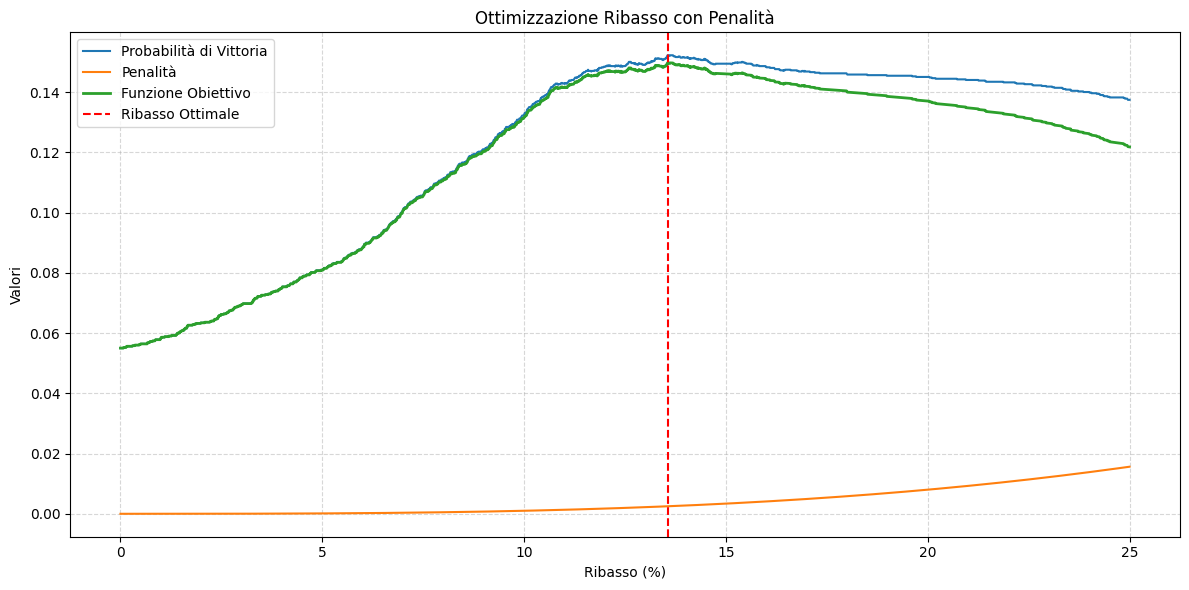

In [ ]:
result = trova_ribasso_ottimale_con_penalita(

    coeff_penale=1, #   questo parametro penalizza ribassi troppo elevati (da regolare a seconda dei casi, se punteggio economico ad esempio e interdipendente-lineare settare tra 140 e 150)
    n_simulazioni=5000, # numero di gare simulate

    esponente=0.9, # coefficente della formula per calcolo punteggio economico nel caso interdipendente esponenziale (specificato in bando gara)
    X_bilineare=0.85, # coefficente della formula per calcolo punteggio economico nel caso bilineare (specificato in bando gara)

    n_partecipanti=25, # Numero di inviti emessi per la gara

    punteggio_tecnico_max=90, # punteggio tecnico massimo possibile da bando
    minimo_punteggio_tecnico=30, # Punteggio tecnico minimo (se presente nel bando come soglia inserire quello altrimenti stimare una soglia minima)
    punteggio_economico_max=10, # punteggio massimo per ilribasso economico (specificato nel bando)

    riduzione_tempo_min=30, # Riduzione sui tempi minima (se prevista dal bando) in giorni
    riduzione_tempo_max=90, # riduzione sui tempi massima in giorni
    punteggio_tempo_max=0, # punteggio attribuito alla riduzione dei tempi, NOTA BENE: SE LA FORMULA PER IL CALCOLO DEL PUNTEGGIO NON E INTERDIPENDENTE LINEARE ACCORPARE IL PUNTEGGIO TEMPORATE A QUELLO TECNICO

    massimo_ribasso=0.25, # massimo ribasso economico atteso (di default 25% ma se ad esempio presente un'alta percentuale di fotovoltaico considera di alzare a 30%)

    mio_punteggio_tecnico=69, # nostro punteggio tecnico atteso
    mio_ribasso_tempo=90, # nostra offertadi ribasso sui giorni di lavoro

    formula='bilineare', # tipo di formula per il calcolo del ribasso, scegli tra:  'interdipendente_esponenziale', 'interdipendente_lineare', 'bilineare'

    Alpha_tecnico=3, # per ora non toccare
    Beta_tecnico=3, # per ora non toccare

    Alpha_ribasso=3, # COPIA DAL CAMPO EVIDENZIATO IN VERDE SU EXCELL
    Beta_ribasso=7, # COPIA DAL CAMPO EVIDENZIATO IN VERDE SU EXCELL

    Alpha_tempo=1, # per ora non toccare
    Beta_tempo=1, # per ora non toccare

    prob_no_show=0.6 # COPIA DAL CAMPO EVIDENZIATO IN VERDE SU EXCELL

)
